In [1]:
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import fastreg.linear as frl
%matplotlib inline

### Generate Data

In [2]:
st = np.random.RandomState(89320432)
N, K1, K2 = 1_000_000, 10, 100

In [3]:
df = pd.DataFrame({
    'id1': st.randint(K1, size=N),
    'id2': st.randint(K2, size=N),
    'x1': st.randn(N),
    'x2': st.randn(N)
})
df['y'] = 3*df['x1'] + 2*df['x2'] + 0.1*df['id1'] + 0.01*df['id2'] + st.randn(N)
df['lEp'] = 0.6*df['x1'] + 0.2*df['x2'] + 0.2*df['id1']/100 + 0.5*df['id2']/100
df['Ep'] = np.exp(df['lEp'])
df['p'] = np.random.poisson(df['Ep'])
df.head()

,id1,id2,x1,x2,y,lEp,Ep,p
0,4,99,-0.232286,-1.106499,1.111238,0.142329,1.152956,0
1,8,98,0.457063,0.585081,5.948498,0.897254,2.452858,4
2,8,73,0.761536,-0.705039,3.017252,0.696914,2.007547,4
3,8,40,-0.251006,-0.884939,-2.216396,-0.111591,0.894410,2
4,6,90,-1.211539,1.763510,2.938151,0.087778,1.091746,1


### Normal OLS

In [5]:
%time smf.ols('y ~ x1 + x2', data=df).fit().params

CPU times: user 600 ms, sys: 411 ms, total: 1.01 s
Wall time: 222 ms


Intercept    0.944116
x1           2.999261
x2           2.000620
dtype: float64

In [6]:
%time frl.ols(y='y', x=['x1', 'x2'], data=df)

CPU times: user 62.7 ms, sys: 40.9 ms, total: 104 ms
Wall time: 37.8 ms


,coeff,stderr,low95,high95,pvalue
intercept,0.944116,0.001081,0.941998,0.946234,0.0
x1,2.999261,0.001080,2.997144,3.001378,0.0
x2,2.000620,0.001079,1.998505,2.002735,0.0


### Sparse OLS

In [7]:
%time frl.ols(y='y', x=['x1', 'x2'], fe=['id1', 'id2'], data=df)

CPU times: user 687 ms, sys: 45.9 ms, total: 733 ms
Wall time: 734 ms


,coeff,stderr,low95,high95,pvalue
intercept,-0.009189,0.010404,-0.029580,0.011202,0.188546
x1,2.999921,0.000999,2.997962,3.001879,0.000000
x2,2.000417,0.000998,1.998461,2.002374,0.000000
id1=1,0.105988,0.004473,0.097222,0.114754,0.000000
id1=2,0.205539,0.004467,0.196783,0.214295,0.000000
...,...,...,...,...,...
id2=95,0.941612,0.014122,0.913934,0.969290,0.000000
id2=96,0.963148,0.014151,0.935412,0.990885,0.000000
id2=97,0.980529,0.014158,0.952781,1.008278,0.000000
id2=98,1.015244,0.014146,0.987518,1.042970,0.000000


In [8]:
%time _ = frl.ols(y='y', x=['x1', 'x2'], fe=[('id1', 'id2')], data=df)

CPU times: user 797 ms, sys: 56.6 ms, total: 853 ms
Wall time: 854 ms


In [9]:
%time _ = frl.ols(y='y', x=['x1', 'x2'], fe=[('id1', 'id2')], data=df, drop=None, intercept=False)

CPU times: user 736 ms, sys: 27.8 ms, total: 764 ms
Wall time: 770 ms


### Poisson

In [10]:
import tensorflow as tf
import fastreg.general as frg

In [11]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [12]:
%time table = frg.poisson(y='p', x=['x1', 'x2'], fe=['id1', 'id2'], data=df, epochs=3)

Train on 1000000 samples
Epoch 1/3
1000000/1000000 [==============================] - 4s 4us/sample - loss: 0.5235 - accuracy: 0.3219
Epoch 2/3
1000000/1000000 [==============================] - 4s 4us/sample - loss: 0.5151 - accuracy: 0.3216
Epoch 3/3
1000000/1000000 [==============================] - 3s 3us/sample - loss: 0.5150 - accuracy: 0.3216
CPU times: user 18 s, sys: 1 s, total: 19 s
Wall time: 17.2 s


In [13]:
table

,coeff,stderr,low95,high95,pvalue
intercept,0.162204,0.008998,0.144567,0.179841,0.000000e+00
x1,0.593414,0.000787,0.591871,0.594957,0.000000e+00
x2,0.232600,0.000787,0.231058,0.234141,0.000000e+00
id1=1,0.011706,0.003551,0.004745,0.018667,4.900658e-04
id1=2,0.019422,0.003555,0.012455,0.026390,2.333470e-08
...,...,...,...,...,...
id2=95,0.285159,0.011272,0.263068,0.307251,0.000000e+00
id2=96,0.296850,0.011217,0.274864,0.318835,0.000000e+00
id2=97,0.299989,0.011250,0.277938,0.322039,0.000000e+00
id2=98,0.311419,0.011144,0.289576,0.333261,0.000000e+00


In [14]:
coeff = table['coeff'].filter(regex='id2').rename('beta1').rename_axis('id2').reset_index()
coeff['id2'] = coeff['id2'].apply(lambda s: s[4:]).astype(np.int)
coeff['beta0'] = 0.5*coeff['id2']/100
coeff['beta1'] += table.loc['intercept', 'coeff']

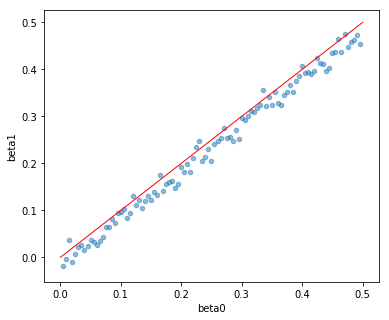

In [15]:
bmax = 0.5*K2/100
beta = np.linspace(0, bmax, 1000)
fig, ax = plt.subplots(figsize=(6, 5))
coeff.plot.scatter(x='beta0', y='beta1', ax=ax, alpha=0.5);
ax.plot(beta, beta, c='r', linewidth=1, zorder=1);